## Q4: Can you detect cascading failures as delays in one airport create delays in others?

### Importing dataset and libraries

In [1]:
import warnings
warnings.filterwarnings('ignore') # This ignores warnings that appear with ouputs

In [2]:
import numpy as np
import pandas as pd

fullset = pd.read_csv('../datasets/fullset cleaned.csv')

### Data Wrangling

In [19]:
fullset.columns

Index(['Unnamed: 0', 'Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime',
       'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum',
       'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
       'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [20]:
# Subsetting the columns needed

Q4 = fullset[['Year', 'Month', 'DayofMonth','TailNum','ArrDelay','DepDelay','CRSDepTime', 'CRSArrTime','Origin', 'Dest']]
Q4

,Year,Month,DayofMonth,TailNum,ArrDelay,DepDelay,CRSDepTime,CRSArrTime,Origin,Dest
0,2006,1,11,N657AW,6.0,-2.0,745,1018,ATL,PHX
1,2006,1,11,N834AW,-5.0,0.0,1053,1318,ATL,PHX
2,2006,1,11,N605AW,-23.0,0.0,1915,2133,ATL,PHX
3,2006,1,11,N312AW,-8.0,-2.0,1755,1933,AUS,PHX
4,2006,1,11,N309AW,0.0,-8.0,832,1015,AUS,PHX
...,...,...,...,...,...,...,...,...,...,...
14279085,2007,12,15,N670DN,13.0,-7.0,1605,1736,MCO,ATL
14279086,2007,12,15,N829MH,5.0,11.0,1851,2105,ATL,SLC
14279087,2007,12,15,N623DL,15.0,-1.0,1025,1735,LAX,ATL
14279088,2007,12,15,N970DL,36.0,38.0,1315,1622,DFW,ATL


In [21]:
Q4['TailNum'].value_counts().sort_index() # Checking for inconsistent values

0          174
80009E    1956
80019E    1897
80059E    1836
80129E    1894
          ... 
N998CA    3148
N998DL    3270
N999CA    3189
N999DN    3310
NHZOAL      89
Name: TailNum, Length: 5811, dtype: int64

In [48]:
Q4 = Q4[Q4['TailNum'] != '0'] # Removing inconsistent values

In [47]:
# Introducing dummy variables for Arrival and Departure delay, where 1=Delayed delay>15mins and 0=Not delayed

Q4['ArrDelayed'] = np.where(Q4["ArrDelay"] > 15, 1, 0) 
Q4['DepDelayed'] = np.where(Q4["DepDelay"] > 15, 1, 0) 

Q4 = Q4.rename(columns ={'DayofMonth':'Day'})  # Renaming the day of month column to Day to use in the datetime function

Q4['Date'] = pd.to_datetime(Q4[['Year','Month','Day']]) # Column of dates

In [45]:
# Subsetting the flights with either an arrival or departure delay or both

casc_del = Q4[(Q4['DepDelayed'] == 1) | (Q4['ArrDelayed'] == 1)][['Date','CRSDepTime','CRSArrTime','TailNum',
                                                                  'Origin','Dest','DepDelayed','ArrDelayed']]

In [46]:
# Sorting values to group together the routes taken by a particular tail number in a day 

casc_del = casc_del.sort_values(['Date','TailNum', 'CRSDepTime']).reset_index(drop=True)
casc_del

,Date,CRSDepTime,CRSArrTime,TailNum,Origin,Dest,DepDelayed,ArrDelayed
0,2006-01-01,1259,1558,N050AA,SJU,JFK,1,1
1,2006-01-01,1855,2206,N050AA,JFK,MIA,0,1
2,2006-01-01,1000,1205,N051AA,SJU,MCO,1,1
3,2006-01-01,1310,1649,N051AA,MCO,SJU,1,1
4,2006-01-01,1835,2142,N051AA,SJU,JFK,1,1
...,...,...,...,...,...,...,...,...
3715339,2007-12-31,1449,1825,N998AT,MKE,MCO,1,1
3715340,2007-12-31,1818,2027,N998AT,MCO,DAY,1,1
3715341,2007-12-31,710,1010,N998DL,ORD,ATL,1,1
3715342,2007-12-31,700,902,N999DN,DCA,ATL,0,1


In [26]:
# Here we define a cascading delay as: a late arriving inbound flight that departs late 
# and then subsequently arrives late at its next destination. 

# Checking if both conditions above are met, 1- Arrival delay, 2-Departure delay and arrival delay in the next route
# and assigning True/False values to a new column "is_casc_del"

casc_del['is_casc_del'] = (casc_del.ArrDelayed.eq(1).groupby(casc_del.TailNum).shift(fill_value=False)
 & casc_del[["DepDelayed", "ArrDelayed"]].eq(1).all(axis=1))
casc_del

,Date,CRSDepTime,CRSArrTime,TailNum,Origin,Dest,DepDelayed,ArrDelayed,is_casc_del
0,2006-01-01,1259,1558,N050AA,SJU,JFK,1,1,False
1,2006-01-01,1855,2206,N050AA,JFK,MIA,0,1,False
2,2006-01-01,1000,1205,N051AA,SJU,MCO,1,1,False
3,2006-01-01,1310,1649,N051AA,MCO,SJU,1,1,True
4,2006-01-01,1835,2142,N051AA,SJU,JFK,1,1,True
...,...,...,...,...,...,...,...,...,...
3715339,2007-12-31,1449,1825,N998AT,MKE,MCO,1,1,False
3715340,2007-12-31,1818,2027,N998AT,MCO,DAY,1,1,True
3715341,2007-12-31,710,1010,N998DL,ORD,ATL,1,1,True
3715342,2007-12-31,700,902,N999DN,DCA,ATL,0,1,False


In [27]:
# Getting the proportion of routes that had a cascading delay and those that didn't

casc_del['Proportion'] = 1 #Dummy variable to use for counts

# Getting proportion of arrival delays that lead to further delays at other airports

casc_del = casc_del[['is_casc_del', 'Proportion']].groupby(['is_casc_del']).count()

casc_del['Proportion'] = (casc_del['Proportion'])/sum(casc_del['Proportion'])

In [28]:
casc_del

,Proportion
is_casc_del,
False,0.407188
True,0.592812


### Visualizing

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

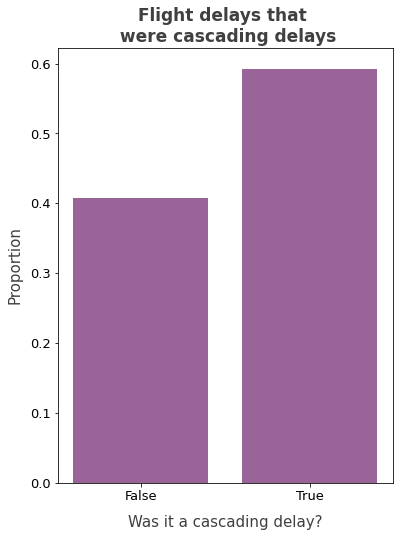

In [42]:
# Column Plot
fig, ax = plt.subplots(1, 1, figsize = (6, 8))


ax.bar(['False', 'True'], 
          casc_del['Proportion'],
          color='#996598')

ax.set_ylabel('Proportion',
                 color='#404040',
                 size = 15,
                 labelpad=8)
ax.set_xlabel('Was it a cascading delay?',
                 color='#404040',
                 size = 15,
                 labelpad=12)
ax.set_title("Flight delays that \n were cascading delays",
                color='#404040',
                size = 17,
                weight = 'bold')

ax.tick_params(axis='y', labelsize=13)
ax.tick_params(axis='x', labelsize=13)

plt.savefig('Casc Del.png')